In [1]:
import numpy as np
import math
import scipy.optimize
import time
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(5)
np.set_printoptions(precision=4)

In [2]:
def generateModel_sparse(agentN, locN, stageN, sparseProb=0.6, isPrintModel=True):
    # Generate the prior distribution vector
    priorVec = np.random.random(locN)
    priorVec /= priorVec.sum()
    if isPrintModel:
        print('The prior probability vector is:\n' + str(priorVec) + '\n')

    # Generate the Markov transition probability matrix (left stochastic matrix; each column sums up to one)
    tranProbMat = np.random.rand(locN, locN)
    tranProbMat /= tranProbMat.sum(axis=0)[None,:]
    if isPrintModel:
        print('The Markov transition probability matrix (x=Px) is:\n' + str(tranProbMat) + '\n')

    # Generate the probability vector of successful detections (between 0.5 to 1.0)
    detectVec = 1 - 0.5 * np.random.random(locN)
    if isPrintModel:
        print('The probability vector of successful detections is:\n' + str(detectVec) + '\n')

    # Compute the probability vector of missed detections
    missVec = 1 - detectVec
    if isPrintModel:
        print('The probability vector of failed detections is:\n' + str(missVec) + '\n')
        
    # Generate access pairs
    accessSource = dict([(m, []) for m in range(agentN)])  # key=source, value=sinks_from_this_source
    accessSink = dict([(k, []) for k in range(locN)])  # key=sink, value=sources_to_this_sink
    for m in range(agentN):
        for k in range(locN):
            if np.random.binomial(1, sparseProb) == 1:
                accessSource[m].append(k)
                accessSink[k].append(m)
        # If agent m cannot access any location, add one
        if len(accessSource[m]) == 0:
            k = np.random.randint(0, locN)
            accessSource[m].append(k)
            accessSink[k].append(m)
    for k in range(locN):
        # If location k cannot be accessed any agent, add one
        if len(accessSink[k]) == 0:
            m = np.random.randint(0, agentN)
            accessSource[m].append(k)
            accessSink[k].append(m)
    if isPrintModel:
        print(accessSource)
        print(accessSink)
    
    # Return model
    return [priorVec, tranProbMat, detectVec, missVec, accessSource, accessSink]

In [3]:
# agentN - number of agents
agentN = 3
# locN - number of locations
locN = 5
# stageN - number of stages
stageN = 5

[priorVec, _, detectVec, missVec, accessSource, accessSink] = generateModel_sparse(agentN, locN, stageN, sparseProb=0.4, isPrintModel=False)
q = priorVec

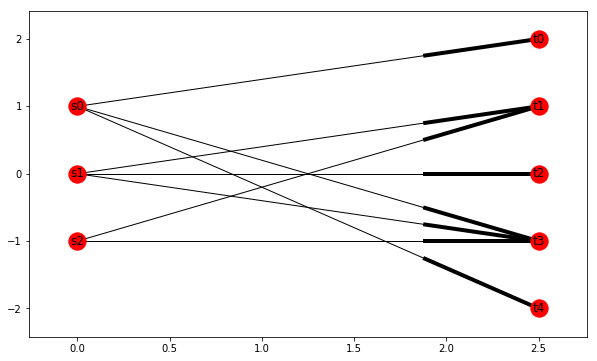

In [4]:
def plot(agentN, locN, accessSource, accessSink):
    G = nx.MultiDiGraph()
    # Add sources
    for m in range(agentN):
        G.add_node('s' + str(m))
    # Add sinks
    for k in range(agentN):
        G.add_node('t' + str(k))
    # Add arcs
    for m in range(agentN):
        for k in accessSource[m]:
            G.add_edge('s' + str(m), 't' + str(k))
    # Configure node positions
    nodes_pos_dict = {}
    for i in range(agentN):
        nodes_pos_dict['s'+str(i)] = (0, - (i - (agentN - 1) / 2))
    for i in range(locN):
        nodes_pos_dict['t'+str(i)] = (locN / 2, - (i - (locN - 1) / 2))
    nodes_pos_dict['gt'] = (locN, 0)
    # Configure plot dimensions
    plt.rcParams['figure.figsize'] = (10, 6)
    # Plot model
    nx.draw_networkx(G, pos = nodes_pos_dict)
    
plot(agentN, locN, accessSource, accessSink)

In [10]:
start_time = time.time()

a = [ 0 ] * locN
b = [ [ 0 ] * locN for m in range(agentN) ] 
prevObjVal = sum(q)

agent_id = 0
itr = 1
while True:
    lamb = 0
    for k in accessSource[agent_id]:
        lamb = max(lamb, -q[k] * math.log(missVec[k]))
    left = 0.0
    right = lamb
    while True:
        # Solve for b_m_k with current lamb
        for k in accessSource[agent_id]:
            if (q[k] * math.log(missVec[k]) + lamb >= 0):
                b[agent_id][k] = 0
            else:
                tmp = -lamb / (q[k] * math.log(missVec[k]))
                b[agent_id][k] = math.log(tmp, missVec[k])
                for m in range(agentN):
                    if m != agent_id:
                        b[agent_id][k] -= b[m][k]
        should_be_one = sum(b[agent_id])
        if math.fabs(should_be_one - 1) <= 1e-14:
            break
        elif should_be_one > 1: # Increase lamb
            tmp = lamb
            lamb = (lamb + right) / 2.0
            left = tmp
        else: # Decrease lamb
            tmp = lamb
            lamb = (left + lamb) / 2.0
            right = tmp
        #print('iter=%s, offset=%.2f, lamb=%.4f, left=%.4f, right=%.4f, right-left=%.2e' % (itr, should_be_one - 1, \
        #      lamb, left, right, right - left))
        itr += 1
    for k in range(locN):
        a[k] = 0
        for m in range(agentN):
            a[k] += b[m][k]
    objVal = sum([q[k] * math.pow(missVec[k], a[k]) for k in range(locN)])
    print('agent %s, iter=%s, objVal=%.10f' % (agent_id, itr, objVal))
    if objVal >= prevObjVal:
        optObjVal = objVal
        break
    prevObjVal = objVal
    agent_id = (agent_id + 1) % agentN

myObjVal = optObjVal
myPlan = a
print('My optimal value: %.4f \nMy search plan: %s \n And b = \n%s' % (myObjVal, myPlan, b))
print('My time taken is %.2f .' % (time.time() - start_time))

agent 0, iter=48, objVal=0.6895883573
agent 1, iter=97, objVal=0.3826818673
agent 2, iter=146, objVal=0.2759024203
agent 0, iter=193, objVal=0.2597110987
agent 1, iter=243, objVal=0.2586299117
agent 2, iter=291, objVal=0.2586299117
agent 0, iter=339, objVal=0.2585285770
agent 1, iter=388, objVal=0.2585199365
agent 2, iter=437, objVal=0.2585199365
My optimal value: 0.2585 
My search plan: [0.3058149663592904, 0.9047254925184565, 0, 1.3082261476404515, 0.4812333934817983] 
 And b = 
[[0.3058149663592904, 0, 0, 0.21295164015890666, 0.4812333934817983], [0, 0.6123154668024782, 0, 0.3876845331975195, 0], [0, 0.2924100257159783, 0, 0.7075899742840254, 0]]
My time taken is 0.00 .


In [6]:
print(sum(myPlan))
for m in range(agentN):
    print(sum(b[m]))

2.999999999999997
0.9999999999999953
0.9999999999999977
1.0000000000000036


In [7]:
a = [ 0.307, 0.904, 1.2433e-8, 1.306, 0.483 ]
optObjVal = sum([q[k] * math.pow(missVec[k], a[k]) for k in range(locN)])
print('%.4f' % (optObjVal))

0.2585


## GAMS

Set m / 0 * 2 / ;
Set k / 0 * 4 / ;
Set mk(m,k) / 0.0, 0.3, 0.4,
              1.1, 1.2, 1.3,
              2.1, 2.3 / ;

Parameters
    q(k)
    / 0 0.082
      1 0.3217
      2 0.0764
      3 0.3394
      4 0.1805 / 
    missVec(k)
    / 0 0.0122
      1 0.1023
      2 0.3499
      3 0.3898
      4 0.0115 / ;

Variables
    a(k)
    b(m,k)
    f ;
    
Nonnegative variables a, b ;

Equations eq1, eq2(k), eq3(m) ; 
eq1.. f =e= sum(k, q(k) * (missVec(k) ** a(k))) ;
eq2(k).. sum(m$mk(m,k), b(m,k)) =e= a(k) ;
eq3(m).. sum(k$mk(m,k), b(m,k)) =e= 1;

Model sparse_subproblem /all/ ;

Solve sparse_subproblem using nlp minimizing f ;
